In [2]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

abbreviation key

gp = games played

net_rating = offRating - defRating

offRating = 100*((points)/POSS)

defRating = 100*((opp points/(opp POSS)))

oreb_pct = offensive rebound percentage

usg_pct = usage percentage is a measurement of the percentage of team plays utilized by a player while they are in the game

ts_pct = true shooting percentage.  percentage of shots made factoring in threes and free throws.  

ast_ptg = assist percentage.  Percent of field goals (2 or 3 point shots not including free throws) 





In [3]:
# !wget https://github.com/morganjng/nba-classifier/blob/main/all_seasons.csv
csv = pd.read_csv("all_seasons.csv")

In [4]:
total_players = len(csv["player_name"])
print(csv.columns, total_players)
for col in csv.columns:
    print(csv[col][0])

Index(['Unnamed: 0', 'player_name', 'team_abbreviation', 'age',
       'player_height', 'player_weight', 'college', 'country', 'draft_year',
       'draft_round', 'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object') 11700
0
Travis Knight
LAL
22.0
213.36
106.59412
Connecticut
USA
1996
1
29
71
4.8
4.5
0.5
6.2
0.127
0.182
0.142
0.536
0.052
1996-97


In [5]:
colleges = []
countries = []
years = []
seasons = []
teams = []
for i in range(0, total_players):
  if(csv["college"][i] not in colleges):
    colleges.append(csv["college"][i])
  if(csv["country"][i] not in countries):
    countries.append(csv["country"][i])
  if(csv["draft_year"][i] not in colleges):
    years.append(csv["draft_year"][i])
  if(csv["season"][i] not in seasons):
    seasons.append(csv["season"][i])
  if(csv["team_abbreviation"][i] not in teams):
    teams.append(csv["team_abbreviation"][i])
print(colleges, countries, years, seasons, teams)

['Connecticut', 'North Carolina-Wilmington', 'Iowa', 'Providence', 'None', 'Seward County Community College', 'Old Dominion', 'Temple', 'Georgia Tech', "St. John's (NY)", 'Washington State', 'Texas Tech', 'Seton Hall', 'American International', 'Massachusetts', 'Murray State', 'Drexel', 'Louisiana State', 'Long Beach State', 'New Mexico', 'Michigan', 'Pennsylvania', 'Michigan State', 'Missouri', 'Louisville', 'Georgetown', 'Louisiana Tech', 'Arkansas', 'Virginia', 'Cincinnati', 'Illinois', 'North Carolina State', 'Montevallo', 'Stetson', 'Wake Forest', 'West Florida', 'Notre Dame', 'UCLA', 'Kansas State', 'George Washington', 'North Carolina', 'Xavier', 'Wisconsin', 'Georgia Southern', 'San Diego State', 'Oklahoma', 'Memphis', 'Mt. San Antonio', 'Alabama', 'Arizona', 'Richmond', 'Syracuse', 'Gonzaga', 'Oklahoma State', 'Detroit Mercy', 'Arkansas-Little Rock', 'Maryland', 'McNeese State', 'Southern Mississippi', 'Purdue', 'Virginia Tech', 'Marquette', 'Ohio State', 'Georgia', 'La Salle'

In [6]:
sum_round = 0
count_round = 0
sum_number = 0
count_number = 0
for i in range(0, total_players):
  if(csv["draft_number"][i] != "Undrafted"):
    sum_number += int(csv["draft_number"][i])
    count_number += 1
  if(csv["draft_round"][i] != "Undrafted"):
    sum_round += int(csv["draft_round"][i])
    count_round += 1

mean_round = sum_round / count_round
mean_number = sum_number / count_number
print(mean_round, mean_number)

1.3026233603997501 21.783007080383175


In [7]:
for i in range(0, total_players):
  if(csv["draft_number"][i] == "Undrafted"):
    csv["draft_number"][i] = mean_number
  if(csv["draft_round"][i] == "Undrafted"):
    csv["draft_round"][i] = mean_round

/tmp/ipykernel_3737/2124559815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_number"][i] = mean_number
/tmp/ipykernel_3737/2124559815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_round"][i] = mean_round


In [8]:
def one_hot(value, array):
  v = [0 for i in range(len(array))]
  v[array.index(value)] = 1
  return torch.Tensor(v)

Data Preprocessing

In [9]:
def random_split(test_percent):
  test_amount = int(total_players * test_percent)
  test_sample = random.sample(range(0,total_players), test_amount)
  train_sample = [i for i in range(0, total_players)]
  test_x = []
  test_y = []
  train_x = []
  train_y = []
  for idx in test_sample:
    train_sample.remove(idx)
    test_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
    test_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
  for idx in train_sample:
    train_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
    train_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
  return train_x, train_y, test_x, test_y

In [11]:
%time train_x, train_y, test_x, test_y = random_split(0.2)

CPU times: user 9.7 s, sys: 209 ms, total: 9.91 s
Wall time: 9.9 s


In [12]:
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

9360 9360
2340 2340


Training

In [42]:
def train(neural_net, optimizer, loss, scheduler, train_features, train_labels, test_features, test_labels, epochs, batch_size, dropout=False):
  xs = [i for i in range(epochs)]
  ys = []
  for epoch in range(epochs):
    count = 0
    rl = 0.0
    neural_net.train()
    optimizer.zero_grad()
    for i in range(len(train_labels)):
      train_y = train_labels[i]
      train_x = train_features[i]
      output = neural_net(train_x)
      out_loss = loss(output, train_y)
      out_loss.backward()
      optimizer.step()
      count += 1
      rl += out_loss.item()
      if count % batch_size == 0:
        optimizer.zero_grad()
        print(str(count) + " completed. Loss: " + str(rl/batch_size))
        rl = 0.0
    scheduler.step()
    epoch_loss = 0.0
    neural_net.eval()
    for i in range(len(test_labels)):
      test_y = test_labels[i]
      test_x = test_features[i]
      output = neural_net(test_x)
      epoch_loss += loss(output, test_y)/float(len(test_labels))
    ys.append(epoch_loss)
  return xs, ys

In [32]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.teamLin = nn.Linear(len(teams), 1)
    self.collegeLin = nn.Linear(len(colleges), 1)
    self.countryLin = nn.Linear(len(countries), 1)
    self.draftLin = nn.Linear(len(years), 1)
    self.seasonLin = nn.Linear(len(seasons), 1)
    self.sequential = nn.Sequential(
        nn.Linear(13, 20),
        #nn.Dropout(p=0.2),
        nn.Linear(20, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 20),
        #nn.Dropout(p=0.2),
        nn.Linear(20, 7),
    )

  def forward(self, x):
    x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
    return self.sequential(x)

In [43]:
class LinearNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.teamLin = nn.Linear(len(teams), 1)
    self.collegeLin = nn.Linear(len(colleges), 1)
    self.countryLin = nn.Linear(len(countries), 1)
    self.draftLin = nn.Linear(len(years), 1)
    self.seasonLin = nn.Linear(len(seasons), 1)
    self.sequential = nn.Sequential(
        nn.Linear(13, 7)
    )

  def forward(self, x):
    x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
    return self.sequential(x)

In [51]:
neural = NeuralNet()
linnet = LinearNet()
loss = nn.MSELoss()
lin_loss = nn.MSELoss()
lin_optim = optim.Adam(linnet.parameters())
optimizer = optim.Adam(neural.parameters())
n_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [49]:
xs, ys = train(neural, optimizer, loss, n_scheduler, train_x, train_y, test_x, test_y, 30, 200)

200 completed. Loss: 4.5941667382791636
400 completed. Loss: 3.751337106740102
600 completed. Loss: 3.437915965907741
800 completed. Loss: 3.650541346091777
1000 completed. Loss: 3.735962356571108
1200 completed. Loss: 3.4431823354028164
1400 completed. Loss: 3.520182787915692
1600 completed. Loss: 3.541836637086235
1800 completed. Loss: 3.805977246919647
2000 completed. Loss: 3.3061861221538855
2200 completed. Loss: 3.7608515130728484
2400 completed. Loss: 3.264845437994227
2600 completed. Loss: 3.6103063186211513
2800 completed. Loss: 3.2670738728297875
3000 completed. Loss: 4.58646967231296
3200 completed. Loss: 3.2813754477957264
3400 completed. Loss: 3.9979306178539993
3600 completed. Loss: 3.9489470396842807
3800 completed. Loss: 3.6200396947935225
4000 completed. Loss: 4.310281424177811
4200 completed. Loss: 3.5601379145029934
4400 completed. Loss: 4.7143753410317
4600 completed. Loss: 4.171609584204853
4800 completed. Loss: 3.909991909014061
5000 completed. Loss: 4.028182061845

4200 completed. Loss: 3.07600875262171
4400 completed. Loss: 3.8979025039821864
4600 completed. Loss: 3.674591745706275
4800 completed. Loss: 3.439269135929644
5000 completed. Loss: 3.2871246498078106
5200 completed. Loss: 3.1185981675889343
5400 completed. Loss: 3.189206418823451
5600 completed. Loss: 3.0868923011887817
5800 completed. Loss: 4.131432702997699
6000 completed. Loss: 2.5650386731885373
6200 completed. Loss: 2.98841505932156
6400 completed. Loss: 3.196696022571996
6600 completed. Loss: 2.8736138159409164
6800 completed. Loss: 2.7615786431171
7000 completed. Loss: 2.690388783812523
7200 completed. Loss: 3.176549417832866
7400 completed. Loss: 2.48560245199129
7600 completed. Loss: 2.8528483681054784
7800 completed. Loss: 3.169244670383632
8000 completed. Loss: 3.3686774255894125
8200 completed. Loss: 5.149467196837068
8400 completed. Loss: 3.304150601439178
8600 completed. Loss: 3.288316773157567
8800 completed. Loss: 3.1366938721109183
9000 completed. Loss: 4.529680420458

8200 completed. Loss: 3.7294970415113493
8400 completed. Loss: 2.9383034012652933
8600 completed. Loss: 3.0072675058431924
8800 completed. Loss: 2.8015835465677084
9000 completed. Loss: 3.7803995250724256
9200 completed. Loss: 3.243424009932205
200 completed. Loss: 3.958068320108578
400 completed. Loss: 3.5196106842625885
600 completed. Loss: 3.1310093124443665
800 completed. Loss: 3.060675651654601
1000 completed. Loss: 3.1542542329616845
1200 completed. Loss: 3.1243072520568966
1400 completed. Loss: 2.8505270125716926
1600 completed. Loss: 2.8532226537819954
1800 completed. Loss: 2.9523772120219656
2000 completed. Loss: 2.828062929708976
2200 completed. Loss: 2.9669912967365235
2400 completed. Loss: 2.579950353174936
2600 completed. Loss: 3.2482333505060526
2800 completed. Loss: 2.5511132909916343
3000 completed. Loss: 3.661224598872941
3200 completed. Loss: 3.0064108958374707
3400 completed. Loss: 3.3889931212295776
3600 completed. Loss: 3.405750882122666
3800 completed. Loss: 2.905

2800 completed. Loss: 2.3702388826338576
3000 completed. Loss: 3.4168384392932056
3200 completed. Loss: 2.740629714354873
3400 completed. Loss: 3.0021843478130177
3600 completed. Loss: 3.245716844620183
3800 completed. Loss: 2.847864986769855
4000 completed. Loss: 3.377179394438863
4200 completed. Loss: 2.603914196062833
4400 completed. Loss: 3.3043060235306623
4600 completed. Loss: 3.2844780397135764
4800 completed. Loss: 3.1527593496628104
5000 completed. Loss: 2.8155458189360796
5200 completed. Loss: 2.6737764394655823
5400 completed. Loss: 2.8833048271760346
5600 completed. Loss: 2.487014993913472
5800 completed. Loss: 3.2618624953227116
6000 completed. Loss: 2.3401522878929972
6200 completed. Loss: 2.56030266309157
6400 completed. Loss: 2.902321315840818
6600 completed. Loss: 2.697248026160523
6800 completed. Loss: 2.411108023785055
7000 completed. Loss: 2.554498761864379
7200 completed. Loss: 2.994172183200717
7400 completed. Loss: 2.5148766659479587
7600 completed. Loss: 2.71311

6600 completed. Loss: 2.809078500608448
6800 completed. Loss: 2.445237971204333
7000 completed. Loss: 2.429057381581515
7200 completed. Loss: 2.7972254552971574
7400 completed. Loss: 2.3407003828696906
7600 completed. Loss: 2.522990572946146
7800 completed. Loss: 2.8450665072724224
8000 completed. Loss: 3.0686359345074745
8200 completed. Loss: 3.6241534048691393
8400 completed. Loss: 2.6929822762124243
8600 completed. Loss: 2.770930481045507
8800 completed. Loss: 2.527748106624931
9000 completed. Loss: 3.383256880361587
9200 completed. Loss: 2.9747596834786236
200 completed. Loss: 3.0855993898026646
400 completed. Loss: 2.8681753550283613
600 completed. Loss: 2.70136372522451
800 completed. Loss: 2.7980100057367236
1000 completed. Loss: 3.071907798096072
1200 completed. Loss: 3.1894917073845863
1400 completed. Loss: 2.70780281720683
1600 completed. Loss: 2.6522025996260346
1800 completed. Loss: 2.723744857853744
2000 completed. Loss: 2.7853043585270645
2200 completed. Loss: 2.791084450

1400 completed. Loss: 2.7127964322920888
1600 completed. Loss: 2.6026963962428273
1800 completed. Loss: 2.6909775036486097
2000 completed. Loss: 2.7665549858566374
2200 completed. Loss: 2.746405058791861
2400 completed. Loss: 2.394709423664026
2600 completed. Loss: 3.0421343685220927
2800 completed. Loss: 2.2046553315687927
3000 completed. Loss: 3.216983344242908
3200 completed. Loss: 2.6410097446246072
3400 completed. Loss: 2.712475806819275
3600 completed. Loss: 3.1651411002874372
3800 completed. Loss: 2.8903641771804542
4000 completed. Loss: 3.256022520605475
4200 completed. Loss: 2.496113986625569
4400 completed. Loss: 3.1869801058992744
4600 completed. Loss: 3.1469492806354538
4800 completed. Loss: 3.0683360544033347
5000 completed. Loss: 2.7171606920473277
5200 completed. Loss: 2.4727661408670247
5400 completed. Loss: 2.7517886503227054
5600 completed. Loss: 2.305729608493857
5800 completed. Loss: 2.8455544510739856
6000 completed. Loss: 2.3033333401940763
6200 completed. Loss: 2

5400 completed. Loss: 2.71100577342324
5600 completed. Loss: 2.2564451004052533
5800 completed. Loss: 2.740836233673617
6000 completed. Loss: 2.2493941407464444
6200 completed. Loss: 2.4065628991182892
6400 completed. Loss: 2.7871622108807785
6600 completed. Loss: 2.412972342937719
6800 completed. Loss: 2.2812520718667657
7000 completed. Loss: 2.314561101682484
7200 completed. Loss: 2.6701899634930304
7400 completed. Loss: 2.2232258397061377
7600 completed. Loss: 2.4732634080294518
7800 completed. Loss: 2.677930399682373
8000 completed. Loss: 2.8198013289202937
8200 completed. Loss: 3.588215560570534
8400 completed. Loss: 2.5263365576742216
8600 completed. Loss: 2.606715107895434
8800 completed. Loss: 2.4425516791944393
9000 completed. Loss: 3.2033153628651054
9200 completed. Loss: 2.8195015132729897
200 completed. Loss: 2.8567300941981375
400 completed. Loss: 2.691483023557812
600 completed. Loss: 2.618004412185401
800 completed. Loss: 2.725456369817257
1000 completed. Loss: 3.0839809

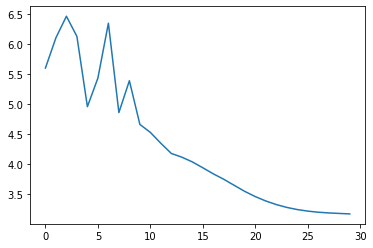

In [50]:
plt.plot(xs,[y.detach() for y in ys])

(array([411., 364., 223., 228., 169., 133., 124., 103., 113.,  79.,  75.,
         69.,  46.,  31.,  40.,  36.,  12.,  17.,  16.,   6.,   9.,   8.,
          7.,   5.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

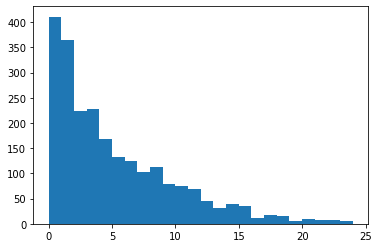

In [48]:
l = []
x = []
for i in range(len(test_x)):
    l.append(loss(neural(test_x[i]), test_y[i]).item())
    x.append(i)
plt.hist(l, range(0,25))

K-fold validation

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.semilogy(range(1, num_epochs + 1), train_ls)
            plt.semilogy(range(1, num_epochs + 1), valid_ls)
            plt.legend(['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k